# Sarcasm Detection using Hybrid Neural Network

**Reconstruction of the model from:**
- Paper: "Sarcasm Detection using Hybrid Neural Network" (Misra & Arora, 2018)
- Repository: https://github.com/rishabhmisra/Sarcasm-Detection-using-NN

## Model Architecture (Exact Benchmark Specifications)

This notebook reconstructs the **exact** Hybrid Neural Network architecture:

1. **Embedding Layer**: 300-dim word2vec embeddings
2. **CNN Module**: 3 parallel ConvNets with filters [4, 6, 8], each outputting 100 features → **300 total**
3. **BiLSTM Module**: 256 hidden units per direction → **512 total** per timestep
4. **Attention Module**: Linear(512→1) attention scores → weighted sum → **512-dim context vector**
5. **Final MLP**: **812** (300 CNN + 512 BiLSTM) → **64** → **50** → **2** classes

**Hyperparameters:**
- Filters: [4, 6, 8]
- CNN out_channels: 100
- LSTM hidden_size: 256 (bidirectional = 512)
- MLP hidden: 64, then 50
- Dropout: 0.2
- Embedding dim: 300
- Batch size: 32
- Learning rate: 0.05
- Optimizer: AdaDelta (rho=0.95, weight_decay=1e-2)
- Epochs: 30

## 1. Setup and Installation

Install required packages and set up the environment for Google Colab.

In [ ]:
# Install required packages (uncomment if running in Colab)
# !pip install torch torchvision pandas numpy matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import time
import sys
import csv
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
from google.colab import drive
drive.mount('/content/drive')
import pickle



# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Mounted at /content/drive
Device: cpu
GPU available: False


## 2. Data Loading and Preprocessing

Load the Headlines dataset and word embeddings. The dataset consists of news headlines from TheOnion (sarcastic) and HuffPost (non-sarcastic).

In [ ]:
class HeadlineDataset(Dataset):
    """Headlines dataset for sarcasm detection."""

    def __init__(self, csv_file, word_embedding_file, pad, whole_data=None,
                 word_idx=None, pretrained_embs=None, max_l=None, transform=None):
        """
        Args:
            csv_file: Path to the csv file with headlines (tab-separated: id, id2, label, text)
            word_embedding_file: Path to word embeddings file
            pad: Padding size (max(filter_h) - 1)
            whole_data: Path to full dataset for vocabulary building (only for train set)
            word_idx: Pre-computed word index dictionary (for val/test sets)
            pretrained_embs: Pre-computed embeddings (for val/test sets)
            max_l: Maximum sequence length (for val/test sets)
        """
        csv.field_size_limit(sys.maxsize)
        self.csv = pd.read_csv(csv_file, sep='\t', on_bad_lines='skip', encoding='utf-8')

        self.max_l = 0
        self.pad = pad
        self.transform = transform

        if whole_data is not None:
            # Build vocabulary from whole dataset
            vocab = self.get_vocab(whole_data)
            self.word_idx, self.pretrained_embs = self.load_word2vec(
                word_embedding_file, vocab, word_embedding_file.endswith('.bin'))
            # Get embedding dimension
            self.k = len(self.pretrained_embs[0])
            print(f"Word2vec loaded ({len(self.word_idx)} words, {self.k} dims)")
            self.add_unknown_words(vocab)
            self.pretrained_embs = np.array(self.pretrained_embs)
        else:
            # Use pre-computed vocabulary and embeddings
            self.word_idx = word_idx
            self.pretrained_embs = pretrained_embs
            self.max_l = max_l

    def load_word2vec(self, fname, vocab, binary=True):
        """Loads 300-dim word vectors from word2vec file."""
        word_idx = {}
        pretrained_embs = []
        # Add zero vector for padding (index 0)
        pretrained_embs.append(np.zeros((300,), dtype='float32'))

        with open(fname, "rb") as f:
            header = f.readline()
            vocab_size, layer1_size = map(int, header.split())

            if binary:
                binary_len = np.dtype('float32').itemsize * layer1_size
                for line in range(vocab_size):
                    word = []
                    while True:
                        ch = f.read(1)
                        if ch == b' ':
                            word = b''.join(word).decode('utf-8')
                            break
                        if ch != b'\n':
                            word.append(ch)
                    word_idx[word] = line + 1
                    pretrained_embs.append(np.frombuffer(f.read(binary_len), dtype='float32'))
            else:  # text format
                counter = 1
                for line in f:
                    items = line.decode('utf-8').split()
                    word = items[0]
                    word_idx[word] = counter
                    counter += 1
                    pretrained_embs.append(np.array(items[1:], dtype='float32'))

        return word_idx, pretrained_embs

    def get_vocab(self, whole_data, clean_string=False):
        """Build vocabulary from entire dataset."""
        vocab = defaultdict(int)
        whole_csv = pd.read_csv(whole_data, sep='\t', on_bad_lines='skip', encoding='utf-8')
        for (idx, row) in whole_csv.iterrows():
            if clean_string:
                clean_text = row[3].lower().strip()
            else:
                clean_text = row[3].lower()
            words = clean_text.split()
            if self.max_l < len(words):
                self.max_l = len(words)
            for word in set(words):
                vocab[word] += 1
        return vocab

    def add_unknown_words(self, vocab, min_df=1):
        """Add unknown words to vocabulary with random embeddings."""
        counter = len(self.pretrained_embs)
        for word in vocab:
            if word not in self.word_idx and vocab[word] >= min_df:
                self.word_idx[word] = counter
                counter += 1
                # Random initialization with variance similar to pre-trained embeddings
                self.pretrained_embs.append(np.random.uniform(-0.25, 0.25, self.k))

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        label = int(self.csv.iloc[idx, 2])
        sent = str(self.csv.iloc[idx, 3])

        # Left padding
        x = [0] * self.pad
        words = sent.lower().split()[:self.max_l]  # Truncate if too long

        for word in words:
            if word in self.word_idx:
                x.append(self.word_idx[word])

        # Right padding
        while len(x) < self.max_l + 2 * self.pad:
            x.append(0)

        return np.array(x, dtype=np.int64), label, sent

## 3. Model Architecture (Exact Benchmark)

Implement the exact Hybrid Neural Network architecture with precise dimensions.

In [ ]:
class ConvNet(nn.Module):
    """Single convolutional network with one filter size."""

    def __init__(self, filter_h, out_channels, max_length, filter_d=300, in_channels=1):
        """
        Args:
            filter_h: Filter height (n-gram size: 4, 6, or 8)
            out_channels: Number of output channels (100)
            max_length: Maximum sequence length after padding
            filter_d: Filter depth (embedding dimension: 300)
            in_channels: Input channels (1)
        """
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(filter_h, filter_d)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(max_length - filter_h + 1, 1))
        )

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, 1, seq_length, 300)
        Returns:
            Flattened output of shape (batch_size, out_channels)
        """
        out = self.layer1(x)
        out = out.view(out.size(0), -1)  # Flatten
        return out


class CUE_CNN(nn.Module):
    """CNN module with 3 parallel convolutional layers."""

    def __init__(self, filters, out_channels, max_length, hidden_units, drop_prob, num_classes=2):
        """
        Args:
            filters: List of filter sizes [4, 6, 8]
            out_channels: Output channels per filter (100)
            max_length: Maximum sequence length
            hidden_units: Not used in CNN module (kept for compatibility)
            drop_prob: Not used in CNN module (kept for compatibility)
            num_classes: Not used in CNN module (kept for compatibility)
        """
        super(CUE_CNN, self).__init__()
        # Three parallel ConvNets with different filter sizes
        self.conv1 = ConvNet(filters[0], out_channels=out_channels,
                            max_length=max_length - filters[0] + 1)
        self.conv2 = ConvNet(filters[1], out_channels=out_channels,
                            max_length=max_length - filters[1] + 1)
        self.conv3 = ConvNet(filters[2], out_channels=out_channels,
                            max_length=max_length - filters[2] + 1)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, 1, seq_length, 300)
        Returns:
            Concatenated features of shape (batch_size, 300) = 100 + 100 + 100
        """
        out1 = self.conv1(x)  # (batch_size, 100)
        out2 = self.conv2(x)   # (batch_size, 100)
        out3 = self.conv3(x)   # (batch_size, 100)
        out = torch.cat((out1, out2, out3), dim=1)  # (batch_size, 300)
        return out

In [ ]:
class MixtureOfExperts(nn.Module):
    """
    Hybrid Neural Network: CNN + BiLSTM with Attention

    Exact architecture from the paper:
    - Embedding: 300-dim word2vec
    - CNN: 3 filters [4,6,8] → 100 each → 300 total
    - BiLSTM: 256 hidden per direction → 512 total
    - Attention: 512 → 1 scores → weighted sum → 512 context
    - MLP: 812 (300+512) → 64 → 50 → 2
    """

    def __init__(self, filters, out_channels, max_length, hidden_units, drop_prob,
                 lstm_input_size, hidden_size_lstm, hidden_units_attention,
                 pretrained_weight, num_classes=2):
        """
        Args:
            filters: [4, 6, 8] - CNN filter sizes
            out_channels: 100 - CNN output channels per filter
            max_length: Maximum sequence length
            hidden_units: 64 - MLP hidden layer size
            drop_prob: 0.2 - Dropout probability
            lstm_input_size: 300 - Embedding dimension
            hidden_size_lstm: 256 - LSTM hidden size per direction
            hidden_units_attention: Not used (kept for compatibility)
            pretrained_weight: Pre-trained word embeddings (vocab_size, 300)
            num_classes: 2 - Binary classification
        """
        super(MixtureOfExperts, self).__init__()

        # Embedding layer: vocab_size → 300
        self.embed = nn.Embedding(pretrained_weight.shape[0], pretrained_weight.shape[1])
        self.embed.weight.data.copy_(torch.from_numpy(pretrained_weight))

        # CNN module: 3 filters → 300 features
        self.cue_cnn = CUE_CNN(filters, out_channels, max_length, hidden_units, drop_prob, num_classes)

        # BiLSTM: 300 → 256 per direction → 512 total per timestep
        self.bi_lstm = nn.LSTM(lstm_input_size, hidden_size_lstm, num_layers=1, bidirectional=True)

        # Attention: 512 → 1 (attention scores)
        self.attention_mlp = nn.Linear(hidden_size_lstm * 2, 1)

        # Final MLP: 812 → 64 → 50 → 2
        self.mlp = nn.Sequential(
            nn.Linear(out_channels * 3 + hidden_size_lstm * 2, hidden_units),  # 812 → 64
            nn.Tanh(),
            nn.Dropout(drop_prob),
            nn.Linear(hidden_units, 50),  # 64 → 50
            nn.Tanh(),
            nn.Dropout(drop_prob),
            nn.Linear(50, num_classes)  # 50 → 2
        )

    def forward(self, y, sents=None, vis_attention=False):
        """
        Args:
            y: Input word indices (batch_size, seq_length)
            sents: Original sentences (for attention visualization)
            vis_attention: Whether to visualize attention
        Returns:
            Logits of shape (batch_size, 2)
        """
        # Embedding: (batch_size, seq_length) → (batch_size, seq_length, 300)
        x = self.embed(y)

        # CNN: (batch_size, seq_length, 300) → unsqueeze → (batch_size, 1, seq_length, 300)
        # Output: (batch_size, 300)
        out1 = self.cue_cnn(x.unsqueeze(1))

        # BiLSTM: Input needs to be (seq_length, batch_size, 300)
        # Output: (seq_length, batch_size, 512) → transpose → (batch_size, seq_length, 512)
        out2 = self.bi_lstm(x.transpose(0, 1))[0].transpose(0, 1)

        # Attention scores: (batch_size, seq_length, 512) → (batch_size, seq_length, 1)
        out3 = self.attention_mlp(out2)

        # Attention weights: Softmax over sequence dimension
        # (batch_size, seq_length, 1)
        attention_weights = nn.functional.softmax(out3.view(x.size(0), x.size(1)), dim=1)

        # Weighted sum: attention_weights * BiLSTM_outputs
        # (batch_size, seq_length, 1) * (batch_size, seq_length, 512) → (batch_size, seq_length, 512)
        out4 = torch.mul(attention_weights.unsqueeze(2).repeat(1, 1, out2.size(2)), out2)

        # Context vector: Sum over sequence → (batch_size, 512)
        out5 = torch.sum(out4, dim=1)

        # Concatenate CNN and BiLSTM context: (batch_size, 300 + 512) = (batch_size, 812)
        out = torch.cat((out1, out5), dim=1)

        # Final MLP: (batch_size, 812) → (batch_size, 64) → (batch_size, 50) → (batch_size, 2)
        out = self.mlp(out)

        return out

## 4. Training Functions

Implement training and evaluation functions.

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def train(train_loader, model, criterion, optimizer, epoch, device):
    """Train for one epoch"""
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # Switch to train mode
    model.train()

    end = time.time()
    for i, (input, target, sent) in enumerate(train_loader):
        # Measure data loading time
        data_time.update(time.time() - end)

        # Move to device
        input = input.to(device)
        target = target.to(device)

        # Compute output
        output = model(input)
        loss = criterion(output, target)

        # Measure accuracy and record loss
        prec1 = accuracy(output, target, topk=(1,))[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # Compute gradient and do optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 100 == 0:
            print(f'Epoch: [{epoch}][{i}/{len(train_loader)}]\t'
                  f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  f'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  f'Loss {losses.val:.4f} ({losses.avg:.4f})\t'
                  f'Prec@1 {top1.val:.3f} ({top1.avg:.3f})')

    return top1.avg, losses.avg


def validate(val_loader, model, criterion, device, tag='val'):
    """Evaluate on validation/test set with formatted text confusion matrix"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    all_preds = []
    all_labels = []

    # Switch to evaluate mode
    model.eval()

    print(f"Generating predictions for {len(val_loader.dataset)} samples...")

    with torch.no_grad():
        end = time.time()
        for i, (input, target, sent) in enumerate(val_loader):
            # Move to device
            input = input.to(device)
            target = target.to(device)

            # Compute output
            output = model(input)
            loss = criterion(output, target)

            # Measure accuracy and record loss
            prec1 = accuracy(output, target, topk=(1,))[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # Collect data for Confusion Matrix
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

            # Measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

    # --- Screenshot Style Confusion Matrix Logic ---
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)

    cm = confusion_matrix(y_true, y_pred)
    # Row-wise normalization for percentages
    cm_norm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

    print("\n" + "="*45)
    print(f"{'FINAL TEST REPORT':^45}")
    print("="*45)
    print(f"{'':<18} | {'Pred: NON':<10} | {'Pred: SAR':<10}")
    print("-" * 45)
    print(f"{'Actual: NON':<18} | {cm_norm[0,0]:>8.2f}% | {cm_norm[0,1]:>8.2f}%")
    print("-" * 45)
    print(f"{'Actual: SAR':<18} | {cm_norm[1,0]:>8.2f}% | {cm_norm[1,1]:>8.2f}%")
    print("="*45)

    overall_acc = (np.diag(cm).sum() / cm.sum()) * 100
    print(f"Overall Test Accuracy: {overall_acc:.2f}%")
    # ------------------------------------------------

    print(f'\n{tag}: * Prec@1 {top1.avg:.3f} Loss {losses.avg:.4f}')
    return top1.avg, losses.avg

## 5. Main Execution

Load data, initialize model, and train with exact hyperparameters from the paper.

In [ ]:
# Configuration - EXACT hyperparameters from the paper
filter_h = [4, 6, 8]  # CNN filter sizes
batch_size = 32
learning_rate = 0.05
momentum = 0.95
weight_decay = 1e-2
epochs = 30
print_freq = 100

train_csv = '/content/drive/My Drive/computational_learning/final_project/data/headline_train.txt'
val_csv = '/content/drive/My Drive/computational_learning/final_project/data/headline_val.txt'
test_csv = '/content/drive/My Drive/computational_learning/final_project/data/headline_test.txt'
whole_data = '/content/drive/My Drive/computational_learning/final_project/data/headlines_clean.txt'
embeddings_file = '/content/drive/My Drive/computational_learning/final_project/data/headlines_filtered_embs.txt'

print("Loading datasets...")
# Load training dataset (builds vocabulary)
train_dataset = HeadlineDataset(
    csv_file=train_csv,
    word_embedding_file=embeddings_file,
    pad=max(filter_h) - 1,
    whole_data=whole_data,
)

print(f"Training samples: {len(train_dataset)}")
print(f"Max sequence length: {train_dataset.max_l}")
print(f"Vocabulary size: {len(train_dataset.word_idx)}")
print(f"Embedding shape: {train_dataset.pretrained_embs.shape}")

# Load validation dataset (uses same vocabulary)
val_dataset = HeadlineDataset(
    csv_file=val_csv,
    word_embedding_file=embeddings_file,
    pad=max(filter_h) - 1,
    word_idx=train_dataset.word_idx,
    pretrained_embs=train_dataset.pretrained_embs,
    max_l=train_dataset.max_l,
)

# Load test dataset (uses same vocabulary)
test_dataset = HeadlineDataset(
    csv_file=test_csv,
    word_embedding_file=embeddings_file,
    pad=max(filter_h) - 1,
    word_idx=train_dataset.word_idx,
    pretrained_embs=train_dataset.pretrained_embs,
    max_l=train_dataset.max_l,
)

print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=0, pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True if torch.cuda.is_available() else False
)

Loading datasets...


/tmp/ipython-input-3418705219.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clean_text = row[3].lower()


Word2vec loaded (21553 words, 300 dims)
Training samples: 21366
Max sequence length: 51
Vocabulary size: 28117
Embedding shape: (28118, 300)
Validation samples: 2669
Test samples: 2671


In [ ]:
# saving word_idx dictionary to later evaluations

with open('/content/drive/My Drive/computational_learning/final_project/model_weights/word_idx.pkl', 'wb') as f:
    pickle.dump(train_dataset.word_idx, f)

print('dictinary saved sucessfully')

dictinary saved sucessfully


In [ ]:
# Model parameters - EXACT specifications from the paper
parameters = {
    "filters": filter_h,
    "out_channels": 100,  # CNN output channels per filter
    "max_length": train_dataset.max_l + 2 * (max(filter_h) - 1),
    "hidden_units": 64,  # MLP hidden layer size
    "drop_prob": 0.2,  # Dropout probability
    "lstm_input_size": 300,  # Embedding dimension
    "hidden_size_lstm": 256,  # LSTM hidden size per direction
    "hidden_units_attention": 128,  # Not used but kept for compatibility
}

print("Model Architecture Specifications:")
print(f"  Filters: {parameters['filters']}")
print(f"  CNN out_channels: {parameters['out_channels']} (per filter)")
print(f"  CNN total output: {parameters['out_channels'] * 3} (3 filters)")
print(f"  LSTM hidden_size: {parameters['hidden_size_lstm']} per direction")
print(f"  LSTM total output: {parameters['hidden_size_lstm'] * 2} (bidirectional)")
print(f"  MLP hidden: {parameters['hidden_units']} → 50 → 2")
print(f"  MLP input: {parameters['out_channels'] * 3 + parameters['hidden_size_lstm'] * 2}")
print(f"  Dropout: {parameters['drop_prob']}")
print(f"  Max sequence length: {parameters['max_length']}")

# Initialize model
model = MixtureOfExperts(
    parameters['filters'],
    parameters['out_channels'],
    parameters['max_length'],
    parameters['hidden_units'],
    parameters['drop_prob'],
    parameters['lstm_input_size'],
    parameters['hidden_size_lstm'],
    parameters['hidden_units_attention'],
    train_dataset.pretrained_embs
)

# Move model to device
model = model.to(device)

# Print model summary
print("\nModel created successfully!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Verify architecture with a dummy input
print("\nVerifying architecture with dummy input...")
dummy_input = torch.randint(0, 1000, (2, parameters['max_length'])).to(device)
with torch.no_grad():
    dummy_output = model(dummy_input)
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {dummy_output.shape}")
    print("✓ Architecture verification passed!")

Model Architecture Specifications:
  Filters: [4, 6, 8]
  CNN out_channels: 100 (per filter)
  CNN total output: 300 (3 filters)
  LSTM hidden_size: 256 per direction
  LSTM total output: 512 (bidirectional)
  MLP hidden: 64 → 50 → 2
  MLP input: 812
  Dropout: 0.2
  Max sequence length: 65

Model created successfully!
Total parameters: 10,174,381
Trainable parameters: 10,174,381

Verifying architecture with dummy input...
Input shape: torch.Size([2, 65])
Output shape: torch.Size([2, 2])
✓ Architecture verification passed!


In [ ]:
# Define loss function and optimizer - EXACT from paper
criterion = nn.CrossEntropyLoss().to(device)

# AdaDelta optimizer with exact parameters from paper
optimizer = optim.Adadelta(
    model.parameters(),
    lr=learning_rate,
    rho=momentum,
    weight_decay=weight_decay
)

# Learning rate scheduler (decay by 0.8 every 10 epochs)
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 0.8 every 10 epochs"""
    lr = learning_rate * (0.8 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

print("Optimizer: AdaDelta")
print(f"  Initial LR: {learning_rate}")
print(f"  Rho (momentum): {momentum}")
print(f"  Weight decay: {weight_decay}")
print(f"  LR decay: 0.8 every 10 epochs")

Optimizer: AdaDelta
  Initial LR: 0.05
  Rho (momentum): 0.95
  Weight decay: 0.01
  LR decay: 0.8 every 10 epochs


In [ ]:
# Training loop
best_val_acc = 0
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []
test_acc_history = []
test_loss_history = []

print("Starting training...")
print("=" * 80)

for epoch in range(epochs):
    # Adjust learning rate
    current_lr = adjust_learning_rate(optimizer, epoch)

    # Train for one epoch
    train_acc, train_loss = train(train_loader, model, criterion, optimizer, epoch, device)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    # Evaluate on validation set
    val_acc, val_loss = validate(val_loader, model, criterion, device, tag='Val')
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)

    # Evaluate on test set
    test_acc, test_loss = validate(test_loader, model, criterion, device, tag='Test')
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)

    # Save best model
    is_best = val_acc > best_val_acc
    best_val_acc = max(val_acc, best_val_acc)

    if is_best:
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'train_acc_history': train_acc_history,
            'train_loss_history': train_loss_history,
            'val_acc_history': val_acc_history,
            'val_loss_history': val_loss_history,
            'test_acc_history': test_acc_history,
            'test_loss_history': test_loss_history,
        }, 'best_model.pth')
        print(f"✓ Saved best model (Val Acc: {best_val_acc:.3f})")

    print(f"Epoch {epoch+1}/{epochs} - LR: {current_lr:.6f} - Best Val Acc: {best_val_acc:.3f}")
    print("-" * 80)

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.3f}%")

Starting training...
Epoch: [0][0/668]	Time 0.577 (0.577)	Data 0.006 (0.006)	Loss 0.6932 (0.6932)	Prec@1 46.875 (46.875)
Epoch: [0][100/668]	Time 0.456 (0.500)	Data 0.002 (0.002)	Loss 0.6881 (0.6895)	Prec@1 53.125 (54.239)
Epoch: [0][200/668]	Time 0.463 (0.489)	Data 0.002 (0.002)	Loss 0.6862 (0.6866)	Prec@1 53.125 (55.348)
Epoch: [0][300/668]	Time 0.452 (0.484)	Data 0.002 (0.002)	Loss 0.6912 (0.6847)	Prec@1 53.125 (56.053)
Epoch: [0][400/668]	Time 0.448 (0.483)	Data 0.002 (0.002)	Loss 0.7271 (0.6851)	Prec@1 37.500 (55.782)
Epoch: [0][500/668]	Time 0.463 (0.481)	Data 0.002 (0.002)	Loss 0.6770 (0.6844)	Prec@1 56.250 (56.007)
Epoch: [0][600/668]	Time 0.457 (0.480)	Data 0.002 (0.002)	Loss 0.6773 (0.6841)	Prec@1 56.250 (55.938)
Val: * Prec@1 56.950 Loss 0.6789
Test: * Prec@1 54.399 Loss 0.6845
✓ Saved best model (Val Acc: 56.950)
Epoch 1/30 - LR: 0.050000 - Best Val Acc: 56.950
--------------------------------------------------------------------------------
Epoch: [1][0/668]	Time 0.461 (0.4

## 6. Results and Visualization

Plot training curves and evaluate final model performance.

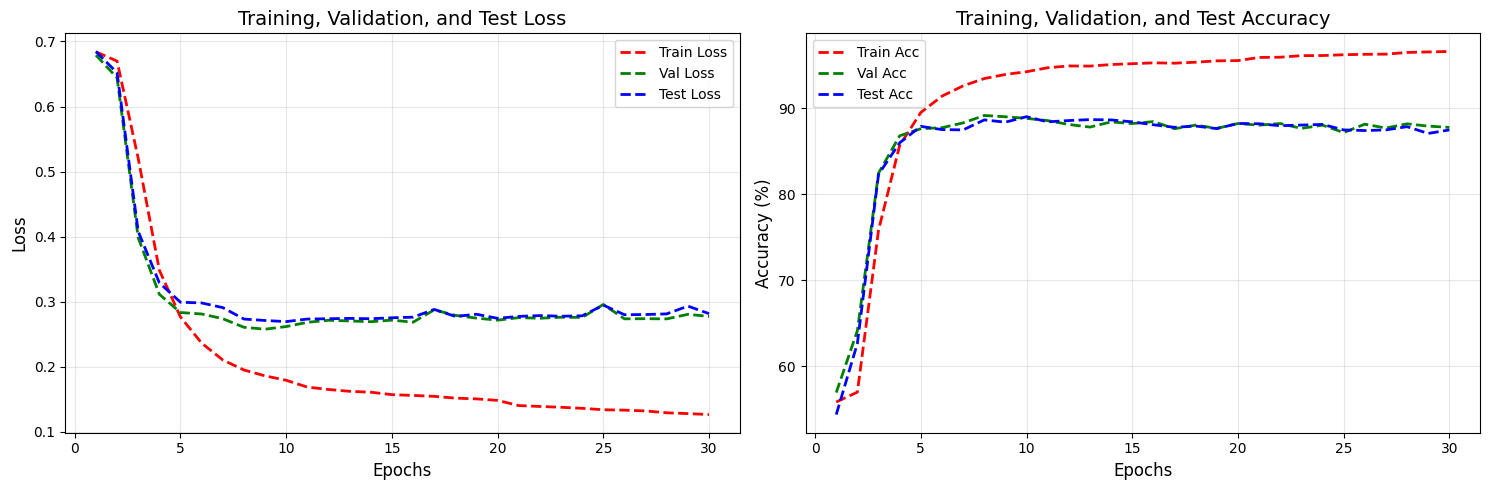

FINAL RESULTS
Best Validation Accuracy: 89.135%
Final Test Accuracy: 87.458%
Final Test Loss: 0.2816


In [ ]:
# Plot training curves
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_history, 'r--', label='Train Loss', linewidth=2)
plt.plot(range(1, epochs + 1), val_loss_history, 'g--', label='Val Loss', linewidth=2)
plt.plot(range(1, epochs + 1), test_loss_history, 'b--', label='Test Loss', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training, Validation, and Test Loss', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_acc_history, 'r--', label='Train Acc', linewidth=2)
plt.plot(range(1, epochs + 1), val_acc_history, 'g--', label='Val Acc', linewidth=2)
plt.plot(range(1, epochs + 1), test_acc_history, 'b--', label='Test Acc', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Training, Validation, and Test Accuracy', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final results
print("=" * 80)
print("FINAL RESULTS")
print("=" * 80)
print(f"Best Validation Accuracy: {best_val_acc:.3f}%")
print(f"Final Test Accuracy: {test_acc_history[-1]:.3f}%")
print(f"Final Test Loss: {test_loss_history[-1]:.4f}")
print("=" * 80)

In [ ]:
#torch.save(model.state_dict(), '/content/drive/My Drive/computational_learning/final_project/base_model_weights.pt')
state_dict = torch.load('/content/drive/My Drive/computational_learning/final_project/model_weights/base_model_weights.pt', map_location=device)
loaded_model = model
loaded_model.load_state_dict(state_dict)
loaded_model.eval()

MixtureOfExperts(
  (embed): Embedding(28118, 300)
  (cue_cnn): CUE_CNN(
    (conv1): ConvNet(
      (layer1): Sequential(
        (0): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(59, 1), stride=(59, 1), padding=0, dilation=1, ceil_mode=False)
      )
    )
    (conv2): ConvNet(
      (layer1): Sequential(
        (0): Conv2d(1, 100, kernel_size=(6, 300), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(55, 1), stride=(55, 1), padding=0, dilation=1, ceil_mode=False)
      )
    )
    (conv3): ConvNet(
      (layer1): Sequential(
        (0): Conv2d(1, 100, kernel_size=(8, 300), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(51, 1), stride=(51, 1), padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (bi_lstm): LSTM(300, 256, bidirectional=True)
  (attention_mlp): Linear(in_features=512, out_features=1, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=812, out_

In [ ]:
# Load best model and evaluate
#checkpoint = torch.load('best_model.pth')
3#model.load_state_dict(checkpoint['state_dict'])
#print(f"Loaded best model from epoch {checkpoint['epoch']}")

# Final evaluation on test set
print("\nFinal evaluation on test set...")
final_test_acc, final_test_loss = validate(test_loader, model, criterion, device, tag='Final Test')
print(f"\nFinal Test Accuracy: {final_test_acc:.3f}%")
print(f"Final Test Loss: {final_test_loss:.4f}")


Final evaluation on test set...
Generating predictions for 2671 samples...

              FINAL TEST REPORT              
                   | Pred: NON  | Pred: SAR 
---------------------------------------------
Actual: NON        |    92.36% |     7.64%
---------------------------------------------
Actual: SAR        |    17.08% |    82.92%
Overall Test Accuracy: 88.06%

Final Test: * Prec@1 88.057 Loss 0.2812

Final Test Accuracy: 88.057%
Final Test Loss: 0.2812
